# Initialisation

In [1]:
from IPython.core.display import HTML
HTML('<style> .container{ width:90%; } </style>')

Installing standard libraries, which only needs to be done once:
- Scientific computing (numpy)
- Data analysis (pandas)
- Plotting (matplotlib, seaborn)
- Machine learning (scikit-learn)
- Gradient-boosted trees (xgboost. lightgbm)
- Deep learning (tensorflow, keras, keras_metrics)

Uncomment for first run!!

In [2]:
'''import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install keras_metrics
!{sys.executable} -m pip install h5py'''

'import sys\n!{sys.executable} -m pip install numpy\n!{sys.executable} -m pip install pandas\n!{sys.executable} -m pip install matplotlib\n!{sys.executable} -m pip install seaborn\n!{sys.executable} -m pip install sklearn\n!{sys.executable} -m pip install xgboost\n!{sys.executable} -m pip install lightgbm\n!{sys.executable} -m pip install tensorflow\n!{sys.executable} -m pip install keras\n!{sys.executable} -m pip install keras_metrics\n!{sys.executable} -m pip install h5py'

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Loading

Loading CVS file onto pandas dataframe, a tabular data structure.

Printing first few rows, the shape of data (rows, column), the data types, and some basic analysis of the numeric features

In [4]:
col_names = [
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num', 
    'marital-status', 
    'occupation', 
    'relationship',
    'race', 
    'sex', 
    'capital-gain', 
    'capital-loss', 
    'hours-per-week', 
    'native-country', 
    'income',
]

df = pd.read_csv('data/census_income.csv', names=col_names, skipinitialspace=True, na_values=['?'])
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [5]:
df.shape

(48842, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         46043 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        46033 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    47985 non-null object
income            48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Based on the data description available at https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names, 
feature 'fnlwgt' does not add any useful information, so it is best to remove.

Feature "education" is also redundant because "education-num" encodes the same information with numerical values.

In [8]:
df = df.drop('fnlwgt', axis=1)
df = df.drop('education', axis=1)

# Exploratory Data Analysis

Check whether numeric features are correlated. Since they are not, all of them bring new relevant information

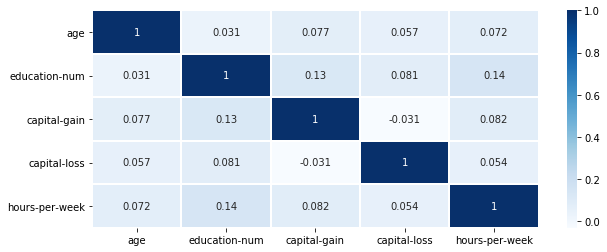

In [9]:
plt.figure(figsize=(10,4))
sns.heatmap(df.corr(), annot=True, cmap='Blues', linecolor='white', linewidths=1)
plt.show()

Plot data to understand it, determine whether any features look strongly correlated with high or low income

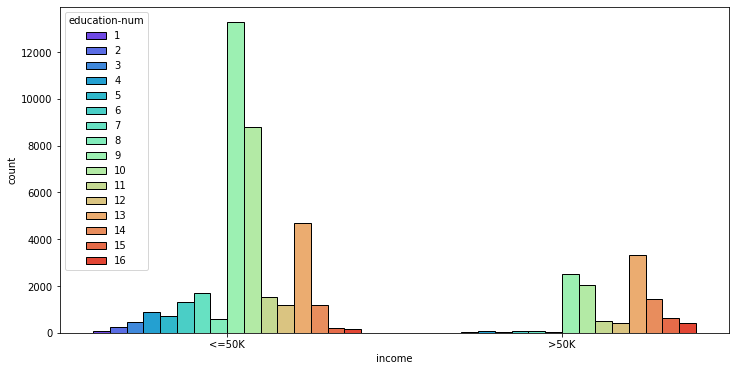

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(x = df['income'], hue = df['education-num'], palette = 'rainbow', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

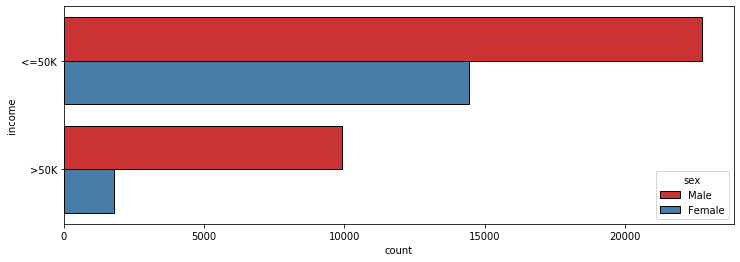

In [11]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['sex'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

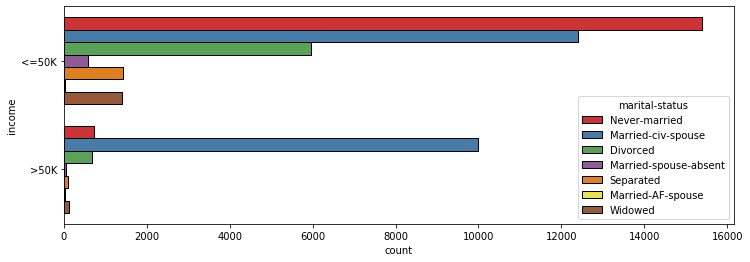

In [12]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['marital-status'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

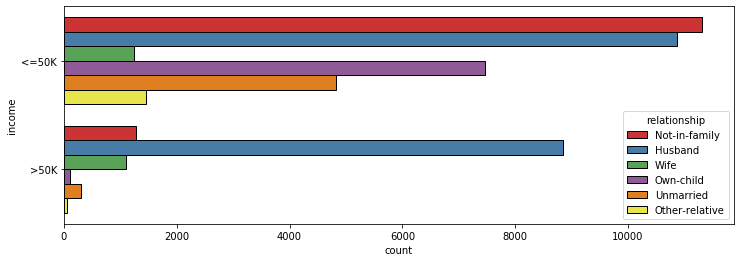

In [13]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['relationship'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

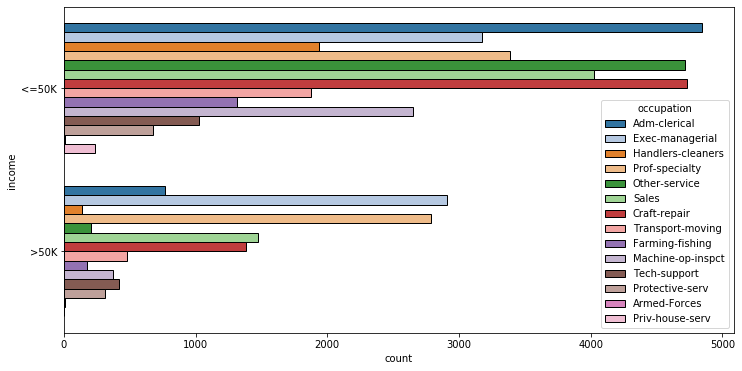

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(y = df['income'], hue = df['occupation'], palette = 'tab20', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

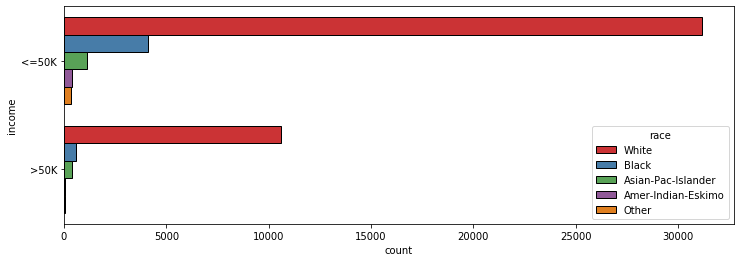

In [15]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['race'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

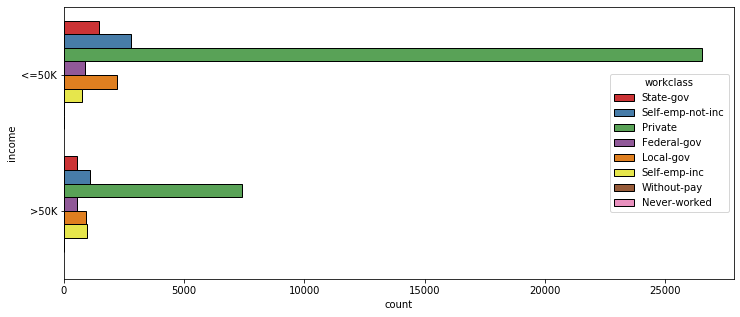

In [16]:
plt.figure(figsize=(12,5))
sns.countplot(y = df['income'], hue = df['workclass'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

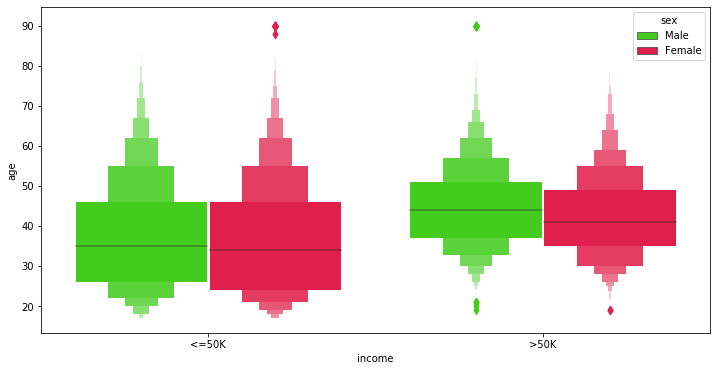

In [17]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='income', y='age', data=df, hue='sex', palette = 'prism')
plt.show()

# Dealing with NULLs

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
age               48842 non-null int64
workclass         46043 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        46033 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    47985 non-null object
income            48842 non-null object
dtypes: int64(5), object(8)
memory usage: 4.8+ MB


In [19]:
df[df.isnull().any(axis=1)]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NaN,>50K
27,54,NaN,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NaN,>50K
51,18,Private,9,Never-married,Other-service,Own-child,White,Female,0,0,30,NaN,<=50K
61,32,NaN,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K
69,25,NaN,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,NaN,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,<=50K
93,30,Private,9,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,NaN,<=50K
106,17,NaN,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,<=50K
128,35,NaN,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,<=50K


In [20]:
df['native-country'].value_counts().head(10)

United-States    43832
Mexico             951
Philippines        295
Germany            206
Puerto-Rico        184
Canada             182
El-Salvador        155
India              151
Cuba               138
England            127
Name: native-country, dtype: int64

In [21]:
df['native-country'].fillna('United-States', inplace=True)
df[df['native-country'].isnull()]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [22]:
df['workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [23]:
df['workclass'].fillna('Private', inplace=True)
df[df['workclass'].isnull()]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [24]:
df['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

In [25]:
df[df.isnull().any(axis=1)]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,Private,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,Private,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,United-States,<=50K
69,25,Private,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,Private,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,<=50K
106,17,Private,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,<=50K
128,35,Private,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,<=50K
149,43,Private,10,Divorced,NaN,Not-in-family,White,Female,0,0,40,United-States,<=50K
154,52,Private,9,Divorced,NaN,Not-in-family,White,Male,0,0,45,United-States,>50K
160,68,Private,2,Divorced,NaN,Not-in-family,White,Female,0,0,20,United-States,<=50K
187,53,Private,13,Divorced,NaN,Not-in-family,White,Female,0,0,50,United-States,<=50K


In [26]:
df.dropna(inplace=True)
df[pd.isnull(df).any(axis=1)]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


# Transforming Categorical Features

In [27]:
tdf = pd.get_dummies(df, columns=[
    'workclass', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex',
    'native-country',
], drop_first=True)

In [28]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46033 entries, 0 to 48841
Data columns (total 81 columns):
age                                          46033 non-null int64
education-num                                46033 non-null int64
capital-gain                                 46033 non-null int64
capital-loss                                 46033 non-null int64
hours-per-week                               46033 non-null int64
income                                       46033 non-null object
workclass_Local-gov                          46033 non-null uint8
workclass_Private                            46033 non-null uint8
workclass_Self-emp-inc                       46033 non-null uint8
workclass_Self-emp-not-inc                   46033 non-null uint8
workclass_State-gov                          46033 non-null uint8
workclass_Without-pay                        46033 non-null uint8
marital-status_Married-AF-spouse             46033 non-null uint8
marital-status_Married-civ-spous

# Train-Test Split

In [29]:
from sklearn.model_selection import train_test_split

Split the dataframe into features (X) and labels(y)

In [30]:
X = tdf.drop('income', axis=1)
y = tdf['income']

Put aside 20% of features to test, train with remaining 80%

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Feature Selection

Now our problem is we have 80 variables to predict a single one. Many of these variables will have absolutely no impact on the income of our citizens, but will add a lot of useless noise to the regression, and may even make it not converge.

We use a little trick called SelectKBest that will give us the k=30 best features based on a standard statistical score. In this case, we use Pearson's Chi Squared test.

In [32]:
from sklearn.feature_selection import SelectKBest, chi2

In [33]:
feature_select = SelectKBest(chi2, k=30)
feature_select.fit(X_train, y_train)

SelectKBest(k=30, score_func=<function chi2 at 0x000002258D160F28>)

List the surviving features, along with their scores

In [34]:
uni_features = list(zip(feature_select.scores_, X_train.columns))
sorted(uni_features, reverse=True)[0:30]

[(93279995.46235263, 'capital-gain'),
 (1525815.0362943537, 'capital-loss'),
 (9395.067151678651, 'age'),
 (6501.215824634082, 'hours-per-week'),
 (3939.4456303764364, 'marital-status_Married-civ-spouse'),
 (2619.0293180999133, 'education-num'),
 (2487.2639014548436, 'marital-status_Never-married'),
 (1536.3941522983832, 'relationship_Own-child'),
 (1379.4624361223182, 'occupation_Exec-managerial'),
 (1029.6665235229539, 'occupation_Prof-specialty'),
 (1023.5043938491883, 'relationship_Not-in-family'),
 (883.781920209376, 'occupation_Other-service'),
 (746.2130721090513, 'relationship_Unmarried'),
 (689.7087874174938, 'workclass_Self-emp-inc'),
 (553.2319167458581, 'sex_Male'),
 (532.1489107019856, 'relationship_Wife'),
 (293.30233352467974, 'occupation_Handlers-cleaners'),
 (272.55198267336095, 'race_Black'),
 (269.5147434748694, 'relationship_Other-relative'),
 (209.00964885172928, 'marital-status_Separated'),
 (204.42326181657438, 'occupation_Machine-op-inspct'),
 (152.5283347563240

# Utility Functions

In [35]:
import warnings
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, auc, \
    roc_auc_score, roc_curve, precision_recall_curve, recall_score, average_precision_score, precision_score
from sklearn.exceptions import DataConversionWarning

metrics = {}

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
joblib.dump(list(X.columns), 'models/columns.pkl')

['models/columns.pkl']

In [36]:
def plot_metrics(classifier, classifier_name):
    prediction = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, pos_label=">50K")
    recall = recall_score(y_test, prediction, pos_label=">50K")
    precision = precision_score(y_test, prediction, pos_label=">50K")
    specificity = recall_score(y_test, prediction, pos_label="<=50K")
    print('Accuracy: %0.3f. Precision: %0.3f. Recall: %0.3f. F1 Score: %0.3f. Specificity: %0.3f' % (accuracy, precision, recall, f1, specificity))
    print(classification_report(y_test, prediction))
    sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt="d")
    metrics[classifier_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
    }
    plt.show()

In [37]:
def plot_roc_curve(classifier, classifier_name):
    try:
        prob_pos = classifier.predict_proba(X_test)[:,1]
    except:
        prob_pos = classifier.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        print('Probabilities estimated from decision function!')
    fpr, tpr, thresholds = roc_curve(y_test, prob_pos, pos_label=">50K")
    plt.figure()
    roc_score = roc_auc_score(y_test, classifier.predict(X_test)==">50K")
    plt.plot(fpr, tpr, label='%s (area = %0.3f)' % (classifier_name, roc_score))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Recall')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('img/ROC_' + classifier_name)
    metrics[classifier_name]['roc_score'] = roc_score
    plt.show()

In [38]:
def plot_precision_recall(classifier, classifier_name):
    try:
        prob_pos = classifier.predict_proba(X_test)[:,1]
    except:
        prob_pos = classifier.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        print('Probabilities estimated from decision function!')
    precision, recall, thresholds = precision_recall_curve(y_test, prob_pos, pos_label=">50K")
    plt.figure()
    #roc_score = recall_score(y_test, classifier.predict(X_test), pos_label=">50K")
    avg_prec = average_precision_score(y_test, prob_pos, pos_label=">50K")
    area = auc(recall, precision)
    plt.plot(recall, precision, label='%s (avg_prec = %0.3f)' % (classifier_name, avg_prec))
    plt.plot([0, 1], [0.5, 0.5], label='Unskilled classifier (coin toss)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.savefig('img/PRC_' + classifier_name)
    metrics[classifier_name]['avg_prec'] = avg_prec
    plt.show()

In [39]:
def plot_cap_curve(classifier, classifier_name):
    from scipy import integrate
    try:
        prob_pos = classifier.predict_proba(X_test)[:,1]
    except:
        prob_pos = classifier.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        print('Probabilities estimated from decision function!')
    y_values = y_test==">50K"
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,prob_pos]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    #print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='dimgrey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label="%s (AR = %0.3f)" % (classifier_name, ar_value))
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label='%0.3f%% of positive obs at %0.1f%%' % (val*100, percent*100))
    
    plt.xlim(-0.05, 1.05)
    plt.ylim(0, 1.05)
    plt.title("Cumulative accuracy profile")
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    plt.savefig('img/CAP_' + classifier_name)
    metrics[classifier_name]['acc_ratio'] = ar_value
    plt.show()

In [40]:
def classify_and_plot(classifier):
    classifier_name = type(classifier).__name__
    if classifier_name == 'Pipeline':
        classifier_name = classifier.steps[-1][0]
    classifier.fit(X_train, y_train)
    plot_metrics(classifier, classifier_name)
    plot_roc_curve(classifier, classifier_name)
    plot_precision_recall(classifier, classifier_name)
    plot_cap_curve(classifier, classifier_name)
    joblib.dump(classifier, 'models/' + classifier_name + '.pkl')
    return classifier

# Classic Data Science Classifiers

## K-nearest Neighbours

Accuracy: 0.826. Precision: 0.693. Recall: 0.585. F1 Score: 0.634. Specificity: 0.910
              precision    recall  f1-score   support

       <=50K       0.86      0.91      0.89      6835
        >50K       0.69      0.58      0.63      2372

    accuracy                           0.83      9207
   macro avg       0.78      0.75      0.76      9207
weighted avg       0.82      0.83      0.82      9207



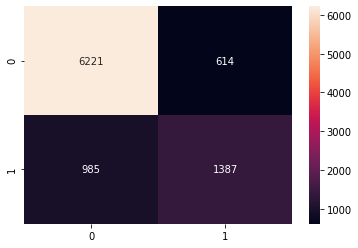

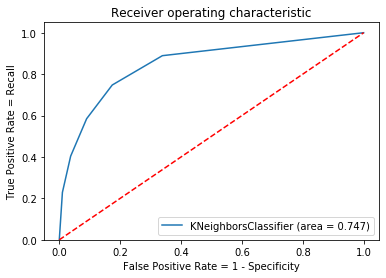

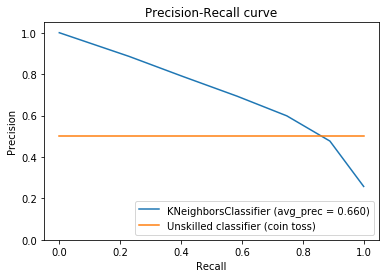

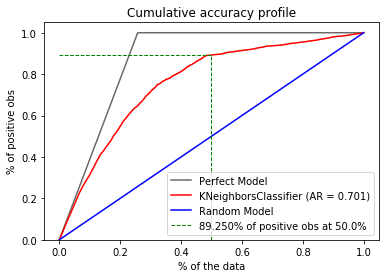

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNeighborsClassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [41]:
from sklearn.neighbors import KNeighborsClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('scaler', StandardScaler()),
    ('KNeighborsClassifier', KNeighborsClassifier()),
])
classify_and_plot(pipeline)

## Logistic Regression

Accuracy: 0.837. Precision: 0.736. Recall: 0.572. F1 Score: 0.644. Specificity: 0.929
              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.89      6835
        >50K       0.74      0.57      0.64      2372

    accuracy                           0.84      9207
   macro avg       0.80      0.75      0.77      9207
weighted avg       0.83      0.84      0.83      9207



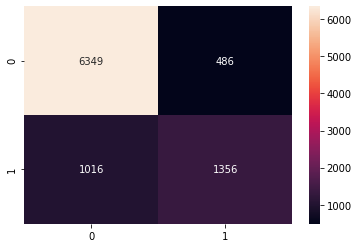

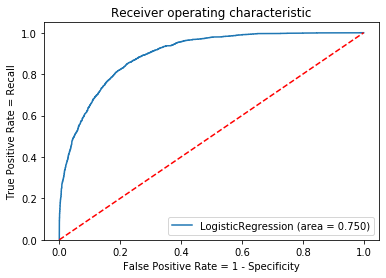

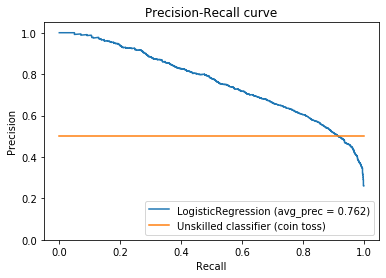

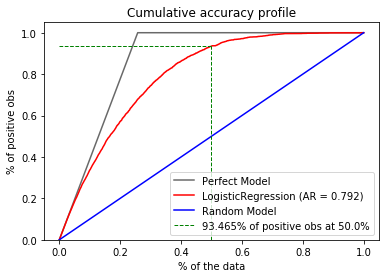

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('LogisticRegression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [42]:
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('select', feature_select),
    ('LogisticRegression', LogisticRegression(solver='liblinear')),
])
classify_and_plot(pipeline)

## Gaussian Naive Bayes

Accuracy: 0.816. Precision: 0.618. Recall: 0.749. F1 Score: 0.677. Specificity: 0.839
              precision    recall  f1-score   support

       <=50K       0.91      0.84      0.87      6835
        >50K       0.62      0.75      0.68      2372

    accuracy                           0.82      9207
   macro avg       0.76      0.79      0.77      9207
weighted avg       0.83      0.82      0.82      9207



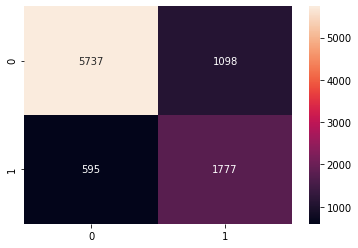

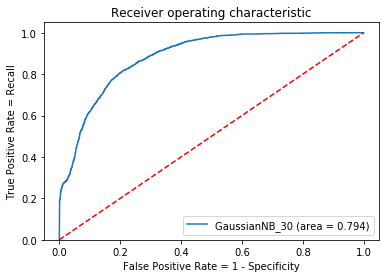

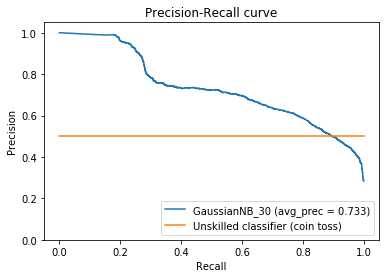

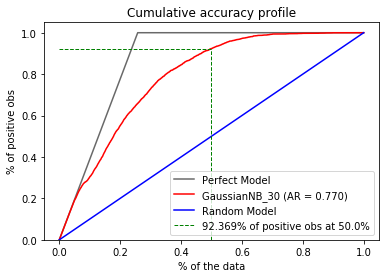

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('GaussianNB_30',
                 GaussianNB(priors=[0.75, 0.25], var_smoothing=1e-09))],
         verbose=False)

In [43]:
from sklearn.naive_bayes import GaussianNB
pipeline = Pipeline([
    ('select', feature_select),
    ('GaussianNB_30', GaussianNB(priors=[0.75, 0.25])),
])
classify_and_plot(pipeline)

Accuracy: 0.812. Precision: 0.613. Recall: 0.737. F1 Score: 0.669. Specificity: 0.838
              precision    recall  f1-score   support

       <=50K       0.90      0.84      0.87      6835
        >50K       0.61      0.74      0.67      2372

    accuracy                           0.81      9207
   macro avg       0.76      0.79      0.77      9207
weighted avg       0.83      0.81      0.82      9207



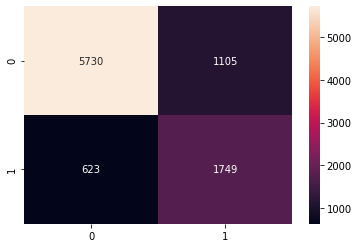

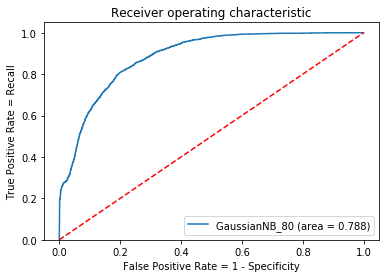

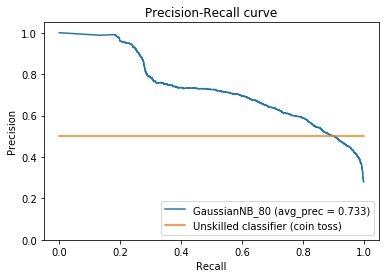

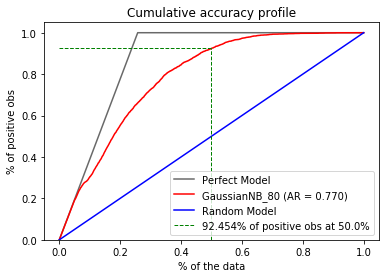

Pipeline(memory=None,
         steps=[('GaussianNB_80',
                 GaussianNB(priors=[0.75, 0.25], var_smoothing=1e-09))],
         verbose=False)

In [44]:
from sklearn.naive_bayes import GaussianNB
pipeline = Pipeline([
    ('GaussianNB_80', GaussianNB(priors=[0.75, 0.25])),
])
classify_and_plot(pipeline)

## Linear Discriminant Analysis

Accuracy: 0.832. Precision: 0.717. Recall: 0.571. F1 Score: 0.636. Specificity: 0.922
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89      6835
        >50K       0.72      0.57      0.64      2372

    accuracy                           0.83      9207
   macro avg       0.79      0.75      0.76      9207
weighted avg       0.82      0.83      0.82      9207



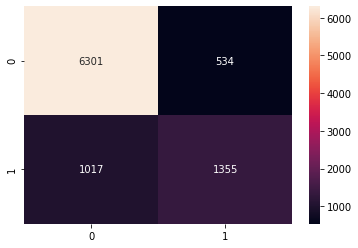

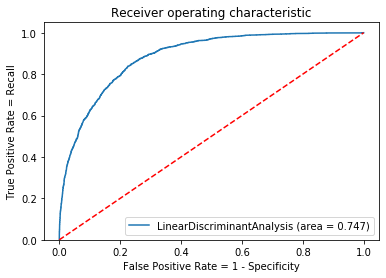

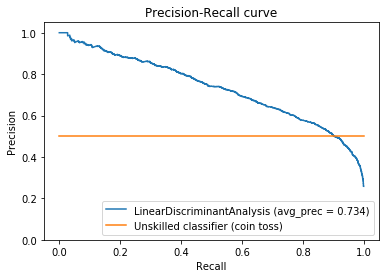

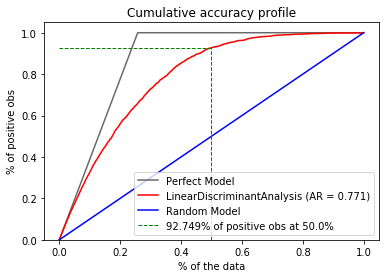

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('LinearDiscriminantAnalysis',
                 LinearDiscriminantAnalysis(n_components=None,
                                            priors=[0.75, 0.25], shrinkage=None,
                                            solver='svd',
                                            store_covariance=False,
                                            tol=0.0001))],
         verbose=False)

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipeline = Pipeline([
    ('select', feature_select),
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(priors=[0.75, 0.25])),
])
classify_and_plot(pipeline)

## Decision Tree

Accuracy: 0.820. Precision: 0.669. Recall: 0.600. F1 Score: 0.633. Specificity: 0.897
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.88      6835
        >50K       0.67      0.60      0.63      2372

    accuracy                           0.82      9207
   macro avg       0.77      0.75      0.76      9207
weighted avg       0.82      0.82      0.82      9207



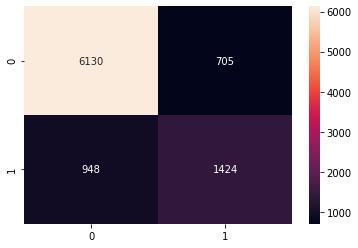

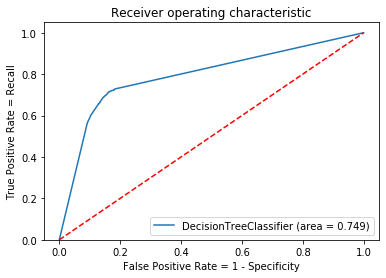

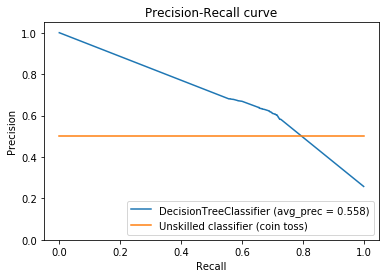

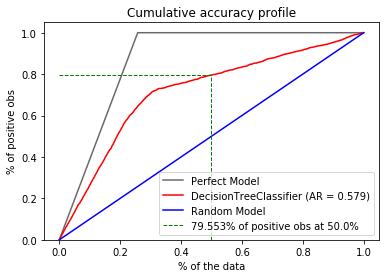

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('DecisionTreeClassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)

In [46]:
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
])
classify_and_plot(pipeline)

If machine has Graphviz (https://www.graphviz.org/) installed, uncomment to render the decision tree as a PDF

In [47]:
'''#!{sys.executable} -m pip install --quiet pydotplus
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(pipeline.steps[-1][1], out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("models/tree.pdf")'''

'#!{sys.executable} -m pip install --quiet pydotplus\nfrom sklearn.externals.six import StringIO  \nfrom sklearn.tree import export_graphviz\nimport pydotplus\n\ndot_data = StringIO()\nexport_graphviz(pipeline.steps[-1][1], out_file=dot_data, filled=True, rounded=True, special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_pdf("models/tree.pdf")'

# Ensemble Classifiers

## Random Forest

Accuracy: 0.840. Precision: 0.724. Recall: 0.613. F1 Score: 0.664. Specificity: 0.919
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      6835
        >50K       0.72      0.61      0.66      2372

    accuracy                           0.84      9207
   macro avg       0.80      0.77      0.78      9207
weighted avg       0.83      0.84      0.84      9207



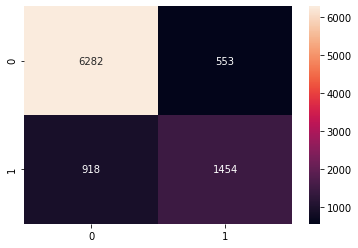

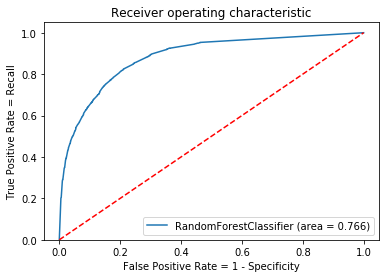

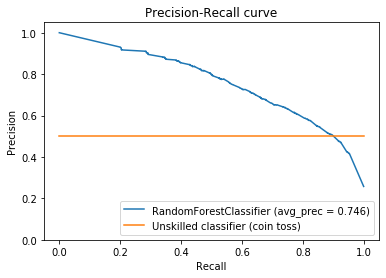

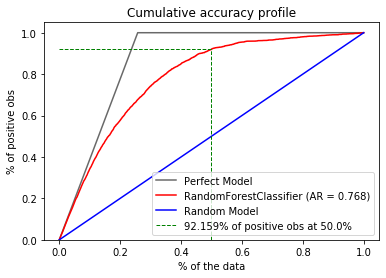

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('RandomForestClassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=20, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

In [48]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=20)),
])
classify_and_plot(pipeline)

## Voting

Accuracy: 0.838. Precision: 0.697. Recall: 0.654. F1 Score: 0.675. Specificity: 0.901
              precision    recall  f1-score   support

       <=50K       0.88      0.90      0.89      6835
        >50K       0.70      0.65      0.67      2372

    accuracy                           0.84      9207
   macro avg       0.79      0.78      0.78      9207
weighted avg       0.83      0.84      0.84      9207



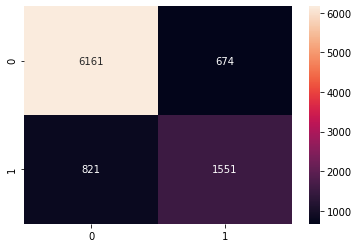

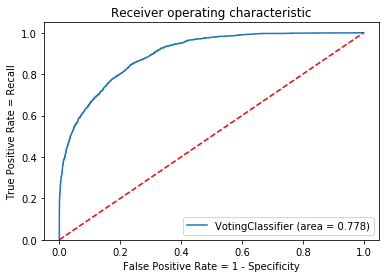

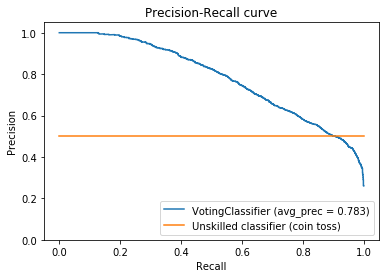

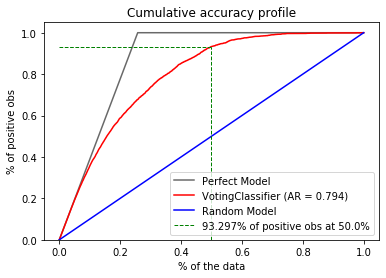

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('VotingClassifier',
                 VotingClassifier(estimators=[('DecisionTreeClassifier',
                                               DecisionTreeClassifier(class_weight=None,
                                                                      criterion='gini',
                                                                      max_depth=None,
                                                                      max_features=None,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                                                      min_samples...
     

In [49]:
from sklearn.ensemble import VotingClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('VotingClassifier', VotingClassifier([
        ('DecisionTreeClassifier', DecisionTreeClassifier()),
        ('GaussianNB_30', GaussianNB(priors=[0.75, 0.25])),        
        ('LogisticRegression', LogisticRegression(solver='liblinear')),
    ], voting='soft')),
])
classify_and_plot(pipeline)

## Gradient Boosting

Accuracy: 0.858. Precision: 0.796. Recall: 0.603. F1 Score: 0.686. Specificity: 0.946
              precision    recall  f1-score   support

       <=50K       0.87      0.95      0.91      6835
        >50K       0.80      0.60      0.69      2372

    accuracy                           0.86      9207
   macro avg       0.83      0.77      0.80      9207
weighted avg       0.85      0.86      0.85      9207



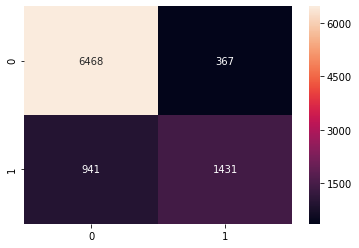

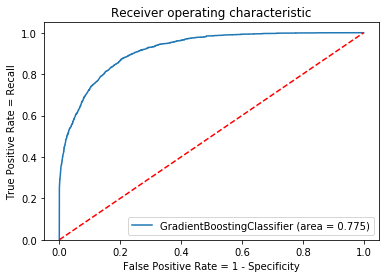

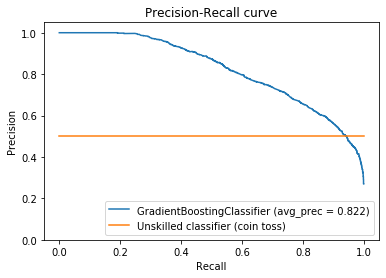

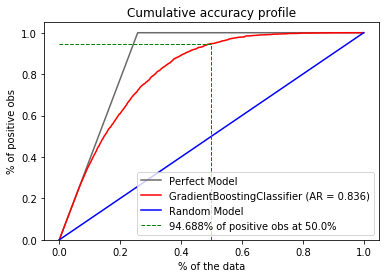

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('GradientBoostingClassifier',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
              

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=100)),
])
classify_and_plot(pipeline)

## AdaBoost

Accuracy: 0.854. Precision: 0.777. Recall: 0.606. F1 Score: 0.681. Specificity: 0.940
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.91      6835
        >50K       0.78      0.61      0.68      2372

    accuracy                           0.85      9207
   macro avg       0.83      0.77      0.79      9207
weighted avg       0.85      0.85      0.85      9207



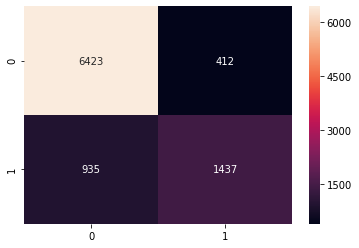

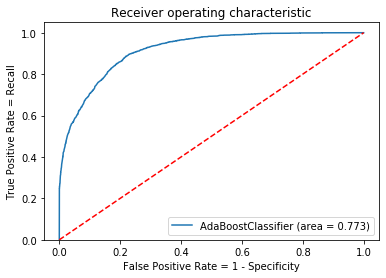

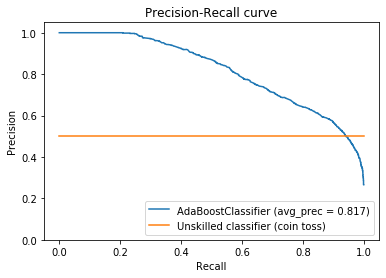

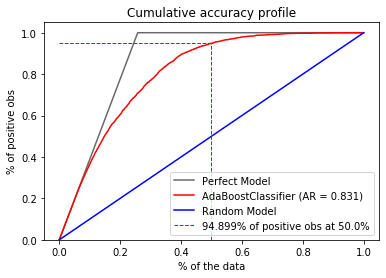

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('AdaBoostClassifier',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=100,
                                    random_state=None))],
         verbose=False)

In [51]:
from sklearn.ensemble import AdaBoostClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('AdaBoostClassifier', AdaBoostClassifier(n_estimators=100)),
])
classify_and_plot(pipeline)

## XGBoost

Accuracy: 0.845. Precision: 0.734. Recall: 0.624. F1 Score: 0.674. Specificity: 0.921
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      6835
        >50K       0.73      0.62      0.67      2372

    accuracy                           0.84      9207
   macro avg       0.80      0.77      0.79      9207
weighted avg       0.84      0.84      0.84      9207



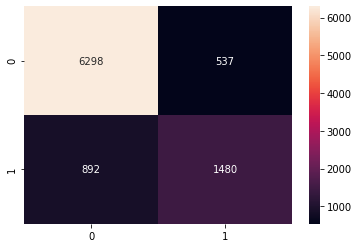

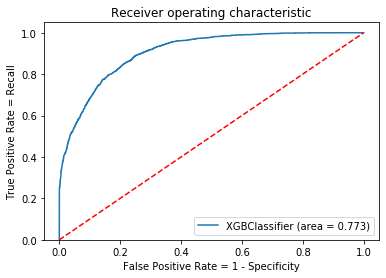

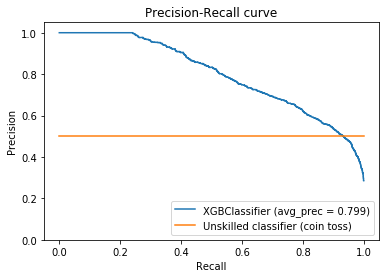

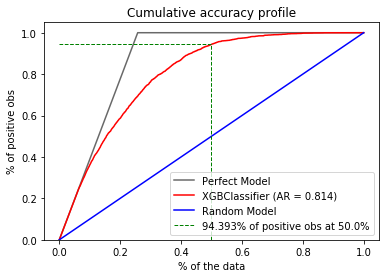

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('XGBClassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=100,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [52]:
from xgboost.sklearn import XGBClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('XGBClassifier', XGBClassifier(max_depth=100)),
])
classify_and_plot(pipeline)

## Microsoft LightGBM

Accuracy: 0.863. Precision: 0.791. Recall: 0.637. F1 Score: 0.706. Specificity: 0.941
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      6835
        >50K       0.79      0.64      0.71      2372

    accuracy                           0.86      9207
   macro avg       0.84      0.79      0.81      9207
weighted avg       0.86      0.86      0.86      9207



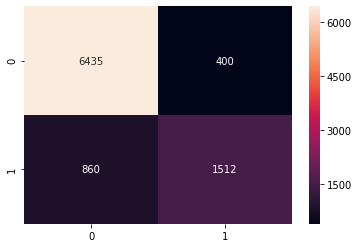

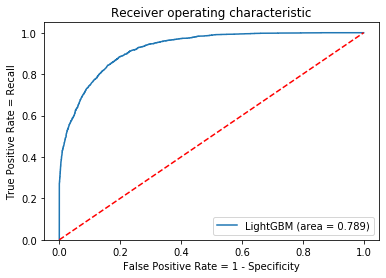

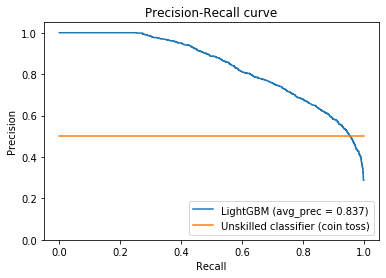

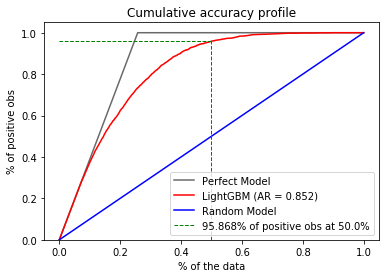

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('LightGBM',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
                                reg_lambda=0.0, silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [53]:
from lightgbm.sklearn import LGBMClassifier
pipeline = Pipeline([
    ('select', feature_select),
    ('LightGBM', LGBMClassifier()),
])
classify_and_plot(pipeline)

# Support Vector Machines

## Linear SVM

c:\portableapps\winpython\python-3.7.0.amd64\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.837. Precision: 0.734. Recall: 0.574. F1 Score: 0.644. Specificity: 0.928
              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.89      6835
        >50K       0.73      0.57      0.64      2372

    accuracy                           0.84      9207
   macro avg       0.80      0.75      0.77      9207
weighted avg       0.83      0.84      0.83      9207



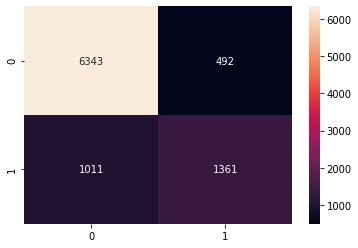

Probabilities estimated from decision function!


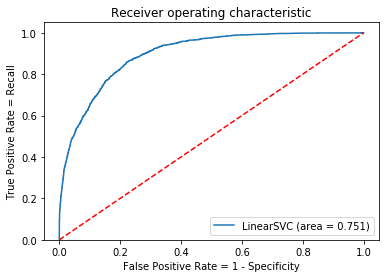

Probabilities estimated from decision function!


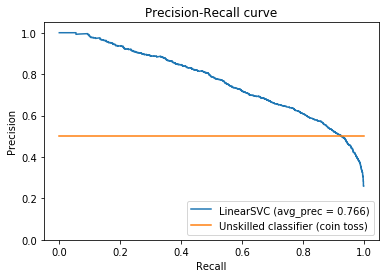

Probabilities estimated from decision function!


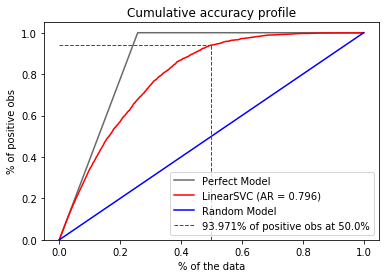

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('LinearSVC',
                 LinearSVC(C=0.2, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [54]:
from sklearn.svm import LinearSVC
pipeline = Pipeline([
    ('select', feature_select),
    ('scaler', StandardScaler()),
    ('LinearSVC', LinearSVC(C=0.2)),
])
classify_and_plot(pipeline)

## SVC with Polynomial Kernel

Accuracy: 0.834. Precision: 0.751. Recall: 0.535. F1 Score: 0.625. Specificity: 0.938
              precision    recall  f1-score   support

       <=50K       0.85      0.94      0.89      6835
        >50K       0.75      0.54      0.62      2372

    accuracy                           0.83      9207
   macro avg       0.80      0.74      0.76      9207
weighted avg       0.83      0.83      0.82      9207



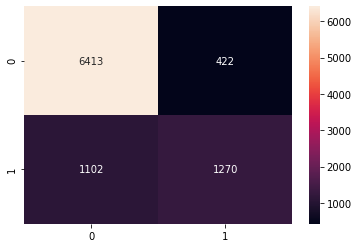

Probabilities estimated from decision function!


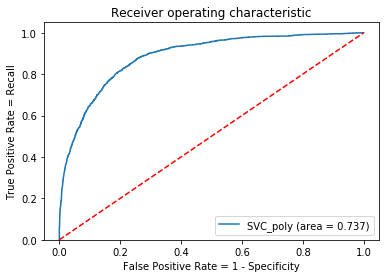

Probabilities estimated from decision function!


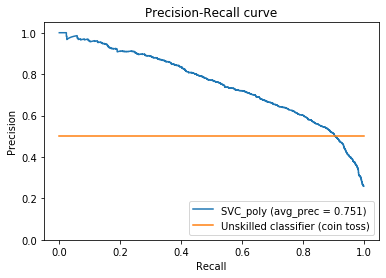

Probabilities estimated from decision function!


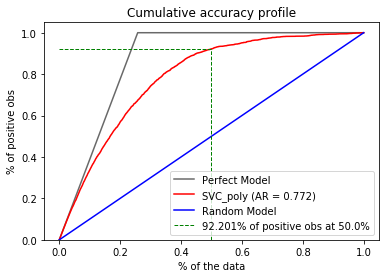

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC_poly',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [55]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('select', feature_select),
    ('scaler', StandardScaler()),
    ('SVC_poly', SVC(C=1.0, kernel='poly', gamma='scale')),
])
classify_and_plot(pipeline)

## SVC with Radial Basis Function Kernel

Accuracy: 0.843. Precision: 0.752. Recall: 0.581. F1 Score: 0.656. Specificity: 0.934
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      6835
        >50K       0.75      0.58      0.66      2372

    accuracy                           0.84      9207
   macro avg       0.81      0.76      0.78      9207
weighted avg       0.84      0.84      0.84      9207



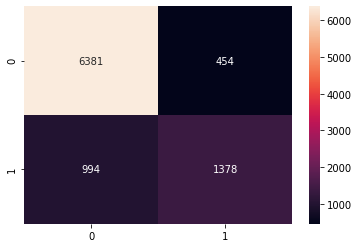

Probabilities estimated from decision function!


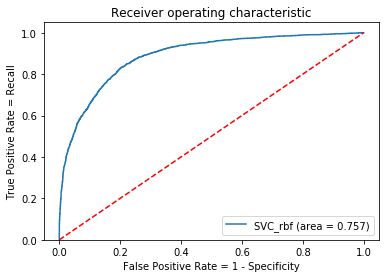

Probabilities estimated from decision function!


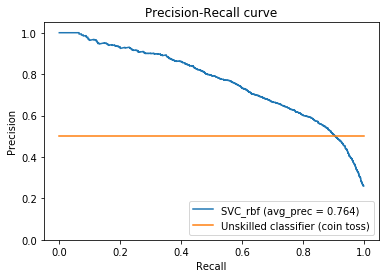

Probabilities estimated from decision function!


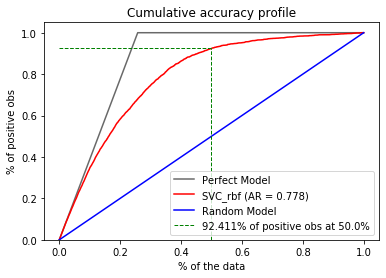

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x000002258D160F28>)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC_rbf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [56]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('select', feature_select),
    ('scaler', StandardScaler()),
    ('SVC_rbf', SVC(C=1.0, kernel='rbf', gamma='scale')),
])
classify_and_plot(pipeline)

# Neural Networks

## Multi-Layer Perceptron

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_metrics

Using TensorFlow backend.


Fully connected layers:
- 80 inputs
- Hidden layer with 40 neurons, ReLU as activation, and dropout rate of 10%
- Hidden layer with 20 neurons, ReLU as activation, and dropout rate of 10%
- 1 single output with sigmoid activation

In [64]:
def create_model():
    model = Sequential()
    model.add(Dense(40, kernel_initializer='normal', activation='relu', input_dim=X_train.shape[1]))
    #model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(rate=0.1))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    #model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
        'accuracy', 
        #keras_metrics.precision(), 
        #keras_metrics.recall()
    ])
    return model

Features must be scaled by subtracting the mean and scaling to unit variance.

Absolute maximum of 250 training epochs, with 2 callbacks:
1. Monitor loss on validation test set (val_loss), and stop training once it stops improving
2. Persist to disk the model state that yielded the best val_loss.

In [67]:
'''checkpoint = ModelCheckpoint('models/best_model.hdf5', monitor='val_acc',
                             mode='max', verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_acc', patience=15, verbose=1, mode='max',
                          restore_best_weights=True)'''

checkpoint = ModelCheckpoint('models/best_model.hdf5', monitor='val_loss',
                             mode='min', verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min',
                          restore_best_weights=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('KerasClassifier', KerasClassifier(build_fn=create_model, epochs=250, batch_size=5, verbose=1, 
                            callbacks=[checkpoint, early_stop], 
                            validation_data=(X_test, y_test==">50K"))),
])

Train on 36826 samples, validate on 9207 samples
Epoch 1/250
36826/36826 [==============================] - 10s 262us/step - loss: 0.3437 - acc: 0.8404 - val_loss: 1.9449 - val_acc: 0.3823
Epoch 2/250
36826/36826 [==============================] - 9s 248us/step - loss: 0.3244 - acc: 0.8495 - val_loss: 1.5164 - val_acc: 0.6345
Epoch 3/250
36826/36826 [==============================] - 9s 250us/step - loss: 0.3205 - acc: 0.8524 - val_loss: 1.6368 - val_acc: 0.7650
Epoch 4/250
36826/36826 [==============================] - 9s 247us/step - loss: 0.3184 - acc: 0.8545 - val_loss: 1.7585 - val_acc: 0.7656
Epoch 5/250
36826/36826 [==============================] - 11s 295us/step - loss: 0.3165 - acc: 0.8537 - val_loss: 1.9656 - val_acc: 0.7656
Epoch 6/250
36826/36826 [==============================] - 10s 263us/step - loss: 0.3163 - acc: 0.8543 - val_loss: 2.1106 - val_acc: 0.7656
Epoch 7/250
36826/36826 [==============================] - 9s 254us/step - loss: 0.3152 - acc: 0.8550 - val_loss: 

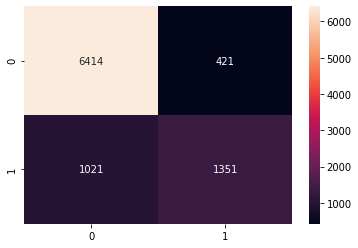

9207/9207 [==============================] - 1s 67us/step


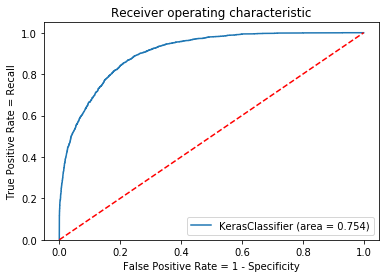

9207/9207 [==============================] - 1s 66us/step


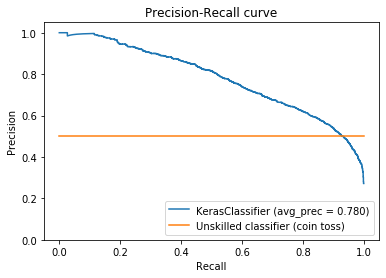

9207/9207 [==============================] - 1s 69us/step


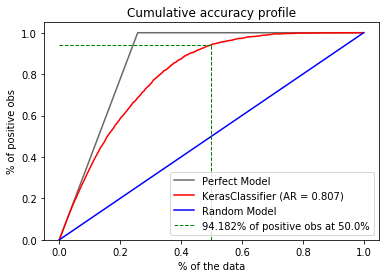

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KerasClassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000225ACED37B8>)],
         verbose=False)

In [68]:
classify_and_plot(pipeline)

# Overall Classifier Ratings

In [69]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_df \
    .sort_values(['accuracy', 'precision', 'recall'], ascending=False).style \
    .background_gradient(cmap="coolwarm") \
    .format('{:.3f}') \
    .set_properties(**{'min-width': '6em'})

,accuracy,precision,recall,f1,specificity,roc_score,avg_prec,acc_ratio
LightGBM,0.863,0.791,0.637,0.706,0.941,0.789,0.837,0.852
GradientBoostingClassifier,0.858,0.796,0.603,0.686,0.946,0.775,0.822,0.836
AdaBoostClassifier,0.854,0.777,0.606,0.681,0.940,0.773,0.817,0.831
XGBClassifier,0.845,0.734,0.624,0.674,0.921,0.773,0.799,0.814
KerasClassifier,0.843,0.762,0.570,0.652,0.938,0.754,0.780,0.807
SVC_rbf,0.843,0.752,0.581,0.656,0.934,0.757,0.764,0.778
RandomForestClassifier,0.840,0.724,0.613,0.664,0.919,0.766,0.746,0.768
VotingClassifier,0.838,0.697,0.654,0.675,0.901,0.778,0.783,0.794
LogisticRegression,0.837,0.736,0.572,0.644,0.929,0.750,0.762,0.792
LinearSVC,0.837,0.734,0.574,0.644,0.928,0.751,0.766,0.796
